# Tutorial: Regularization, Model Selection and Evaluation

Tutorial to the class [Regularization, Model Selection and Evaluation](4_regularization_selection_evaluation.ipynb) based on the same case study as in [Tutorial: Supervised Learning Problem and Least Squares](2_tutorial_supervised_learning_problem_ols.ipynb).

<div class="alert alert-block alert-info">
    <b>Tutorial Objectives</b>
    
- Apply regularization methods: Ridge and Lasso
- Compute and plot validation curves
- Compare $k$-nearest neighbors to Ridge/Lasso
</div>

## Getting ready

Let us follow the same procedure as in [Tutorial: Supervised Learning Problem and Least Squares](2_tutorial_supervised_learning_problem_ols.ipynb) to import the required modules and read the data.

In [1]:
# Path manipulation module
from pathlib import Path
# Numerical analysis module
import numpy as np
# Formatted numerical analysis module
import pandas as pd
# Plot module
import matplotlib.pyplot as plt
# Default colors
RC_COLORS = plt.rcParams['axes.prop_cycle'].by_key()['color']
# Matplotlib configuration
plt.rc('font', size=14)

# Set data directory
data_dir = Path('data')

# Set keyword arguments for pd.read_csv
kwargs_read_csv = dict()

# Set first and last years
FIRST_YEAR = 2014
LAST_YEAR = 2019

# Define temperature filepath and label
temp_filename = 'surface_temperature_merra2_{}-{}.csv'.format(
    FIRST_YEAR, LAST_YEAR)
temp_filepath = Path(data_dir, temp_filename)
temp_label = 'Temperature (°C)'

# Define electricity demand filepath and label
dem_filename = 'reseaux_energies_demand_demand.csv'
dem_filepath = Path(data_dir, dem_filename)
dem_label = 'Electricity consumption (MWh)'

# Read hourly temperature and demand data averaged over each region
df_temp_hourly = pd.read_csv(temp_filepath, index_col=0, parse_dates=True, header=0)
df_dem_hourly = pd.read_csv(dem_filepath, index_col=0, header=0, parse_dates=True)

# Get daily-mean temperature and daily demand
df_temp = df_temp_hourly.resample('D').mean()
df_dem = df_dem_hourly.resample('D').sum()

# Select region
region_name = 'Île-de-France'

df_temp_reg = df_temp[region_name]
df_dem_reg = df_dem[region_name]

## Regularization

### Ridge regression

> ***Question***
> - Apply the ridge regression using `Ridge` from `sklearn.linear_model` to the model with base, heating and cooling variables for varying regularization parameter values with `fit_intercept=False`.
> - Represent the resulting predictions above the scatter plot of the train data.
> - Same questions but with `fit_intercept=True`.
> - Compare the two results and explain the differences.

In [23]:
# Define heating and cooling temperature thresholds
TEMP_HEAT = 15.
TEMP_COOL = 20.

# Define function returning a dictionary from variable name
# to variable train data with base, heating and cooling variables
def get_base_heat_cool(x):
    return {
        'base': np.ones(x.shape),
        'heat': (TEMP_HEAT - x) * (x < TEMP_HEAT).astype(float),
        'cool': (x - TEMP_COOL) * (x > TEMP_COOL).astype(float)
    }

Coefficients: [    0.         16459.87521956  3626.28400577]
Intercept: 307524.77948303823


Text(0.5, 1.0, 'Île-de-France')

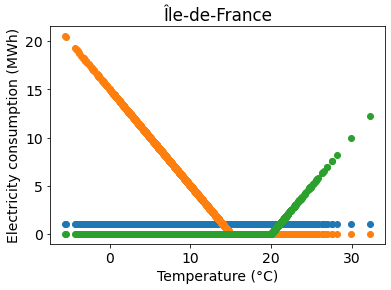

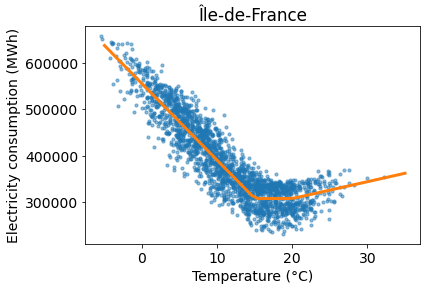

In [24]:
# Import linear_model
from sklearn import linear_model

# Prepare input and target
x = df_temp_reg.values
y = df_dem_reg.values

# Get variables
variables = get_base_heat_cool(x)

# Get input matrix with base, heat and colling variables
X = np.array(list(variables.values())).T

# Plot inputs
plt.figure()
for k in range(X.shape[1]):
    plt.scatter(x, X[:, k])
plt.xlabel(temp_label)
plt.ylabel(dem_label)
plt.title(region_name)

# Set regularization parameter and fit_intercept
alpha = 1.e0
# fit_intercept = False
fit_intercept = True

# Estimator choice
reg_class = linear_model.Ridge

# Define the Ridge estimator
reg = reg_class(alpha=alpha, fit_intercept=fit_intercept)

# Fit 
reg.fit(X, y)
print('Coefficients:', reg.coef_)
print('Intercept:', reg.intercept_)

# Define arbitrary temperatures for prediction
x_pred = np.linspace(-5., 35.)

# Get variables to predict
variables_pred = get_base_heat_cool(x_pred)

# Get input matrix to predict
X_pred = np.array(list(variables_pred.values())).T

# Predict for work days and off days
y_pred = reg.predict(X_pred)

# Plot prediction on top of train data
plt.figure()
plt.scatter(x, y, s=10, alpha=0.5)
plt.plot(x_pred, y_pred, linewidth=3, c=RC_COLORS[1])
plt.xlabel(temp_label)
plt.ylabel(dem_label)
plt.title(region_name)

Answer:

> ***Question***
> - Compute the corresponding validation curves. To do so:
>   - Compute and plot the train and test error (using cross-validation) for varying values of the regularization parameter.
> - What is the best value of the regularization parameter according to your estimations?
> - Is there any overfitting occurring here?

Text(0.5, 1.0, 'Île-de-France. Best $r^2$: 0.84 for $\\alpha$ = 1.4e+02')

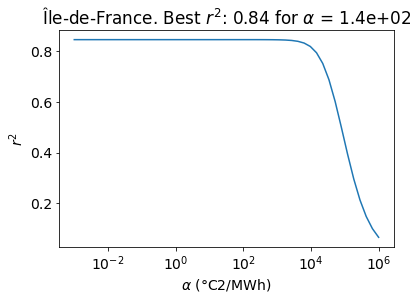

In [25]:
# Import scikit-learn cross-validation function
from sklearn.model_selection import cross_val_score

# Set number of splits for cross-validation
N_SPLITS = 6

# Define array of regularization-parameter values
alpha_rng = np.logspace(-3, 6, 50)
fit_intercept = True

# Declare empty arrays in which to store r2 scores and coefficients
r2_validation = np.empty(alpha_rng.shape)
coefs = np.empty((len(alpha_rng), X.shape[1]))

# Estimator choice
reg_class = linear_model.Ridge

# Loop over regularization-parameter values
for k, alpha in enumerate(alpha_rng):
    # Define the Ridge estimator for particular regularization-parameter value
    reg = reg_class(alpha=alpha, fit_intercept=fit_intercept)

    # Get r2 test scores from k-fold cross-validation
    r2_validation_arr = cross_val_score(reg, X, y, cv=N_SPLITS)
    
    # Get r2 expected prediction score by averaging over test scores
    r2_validation[k] = r2_validation_arr.mean()
    
    # Save coefficients
    reg.fit(X, y)
    coefs[k] = reg.coef_

# Get best value of the regularization parameter
i_best = np.argmax(r2_validation)
alpha_best = alpha_rng[i_best]
r2_best = r2_validation[i_best]
    
# Plot validation curve
alpha_label = r'$\alpha$ (°C2/MWh)'
plt.figure()
plt.plot(alpha_rng, r2_validation)
plt.xscale('log')
plt.xlabel(alpha_label)
plt.ylabel(r'$r^2$')
plt.title(region_name + r'. Best $r^2$: {:.2} for $\alpha$ = {:.1e}'.format(
    r2_best, alpha_best))

Answer:

> ***Question***
> - Plot the values of the estimated coefficients as a function of the regularization parameter.

Text(0.5, 1.0, 'Île-de-France')

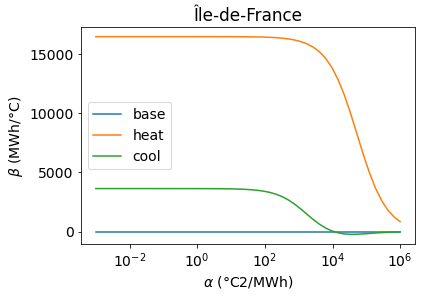

In [26]:
# Plot coefficients
fig, ax = plt.subplots()
df_coefs = pd.DataFrame(coefs, index=alpha_rng, columns=list(variables))
df_coefs.index.name = alpha_label
df_coefs.plot(ax=ax, ylabel=r'$\beta$ (MWh/°C)')
ax.set_xscale('log')
plt.title(region_name)

> ***Question***
> - Give an estimate the prediction error conditioned on some train dataset for the best choice or regularization parameter.
> - Compare the test value of the score to its validation value.

In [27]:
# Compute prediction error conditioned on first 5 years of data
# Number of test days
n_test = 365

# Select test set from last year
X_test = X[-n_test:]
y_test = y[-n_test:]

# Select train set from previous years
X_train = X[:-n_test]
y_train = y[:-n_test]

# Define the Ridge estimator for best regularization parameter
reg = reg_class(alpha=alpha_best, fit_intercept=fit_intercept)

# Fit on train data
reg.fit(X_train, y_train)
print('Coefficients:', reg.coef_)

# Test on test data
r2_test = reg.score(X_test, y_test)

print('Test r2: {:.2f}'.format(r2_test))

Coefficients: [    0.         16293.18312597  3286.21731379]
Test r2: 0.85


Answer:

### Lasso regression

> ***Question***
> - Same questions as for the ridge but for the Lasso (using `Lasso` from `sklearn.linear_model`).
> - How do the coefficients evolve compared to the Ridge?

Test r2: 0.85


Text(0.5, 1.0, 'Île-de-France')

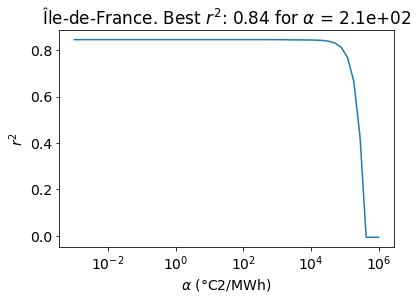

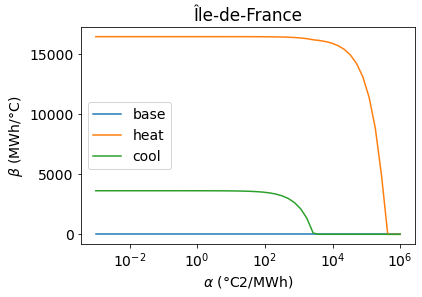

In [28]:
# fit_intercept = False
fit_intercept = True

# Estimator choice
reg_class = linear_model.Lasso

# Declare empty arrays in which to store r2 scores and coefficients
r2_validation = np.empty(alpha_rng.shape)
coefs = np.empty((len(alpha_rng), X.shape[1]))

# Loop over regularization-parameter values
for k, alpha in enumerate(alpha_rng):
    # Define the estimator for particular regularization-parameter value
    reg = reg_class(alpha=alpha, fit_intercept=fit_intercept)

    # Get r2 test scores from k-fold cross-validation
    r2_validation_arr = cross_val_score(reg, X, y, cv=N_SPLITS)
    
    # Get r2 expected prediction score by averaging over test scores
    r2_validation[k] = r2_validation_arr.mean()
    
    # Save coefficients
    reg.fit(X, y)
    coefs[k] = reg.coef_
    
# Get best value of the regularization parameter
i_best = np.argmax(r2_validation)
alpha_best = alpha_rng[i_best]
r2_best = r2_validation[i_best]
    
# Plot validation curve
plt.figure()
plt.plot(alpha_rng, r2_validation)
plt.xscale('log')
plt.xlabel(alpha_label)
plt.ylabel(r'$r^2$')
plt.title(region_name + r'. Best $r^2$: {:.2} for $\alpha$ = {:.1e}'.format(
    r2_best, alpha_best))

# Compute prediction error conditioned on first 5 years of data
X_test = X[-n_test:]
y_test = y[-n_test:]
X_train = X[:-n_test]
y_train = y[:-n_test]
reg = reg_class(alpha=alpha_best, fit_intercept=fit_intercept)
reg.fit(X_train, y_train)
r2_test = reg.score(X_test, y_test)
print('Test r2: {:.2f}'.format(r2_test))

# Plot coefficients
fig, ax = plt.subplots()
df_coefs = pd.DataFrame(coefs, index=alpha_rng, columns=list(variables))
df_coefs.index.name = alpha_label
df_coefs.plot(ax=ax, ylabel=r'$\beta$ (MWh/°C)')
ax.set_xscale('log')
plt.title(region_name)

Answer:

## $K$-nearest neighbor model

> ***Question***
> - Compute and plot the validation curve for the $k$-nearest neighbor model using `KNeighborsRegressor` from `sklearn.neighbors` for varying number of neighbors.
> - For which value of $k$ is the score best? Represent the best prediction above the scatter plot of the train data.
> - Is there any overfitting occurring?
> - How does the best $k$-nearest neighbor model performs compared to the linear models analyzed so far?

Test r2: 0.85


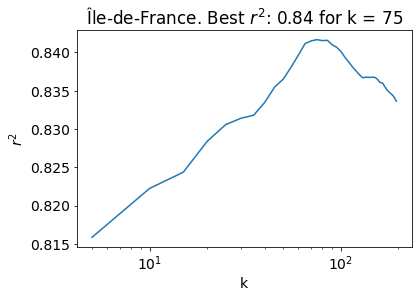

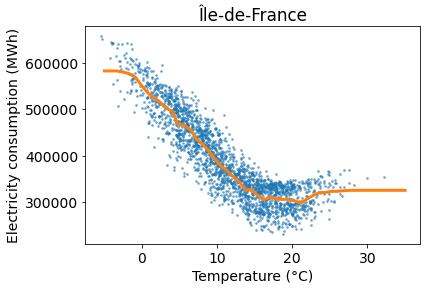

In [29]:
#Import neighbors module from Scikit-Learn
from sklearn import neighbors

# Estimator choice
reg_class = neighbors.KNeighborsRegressor

# Liste of n_neighbors
# nn_rng = np.arange(1, 1000, 50)
nn_rng = np.arange(5, 200, 5)

# Declare empty array in which to store r2 scores
r2_validation = np.empty(nn_rng.shape)

# Loop over regularization-parameter values
for k, nn in enumerate(nn_rng):
    # Define the estimator for particular regularization-parameter value
    reg = reg_class(nn)

    # Get r2 test scores from k-fold cross-validation
    r2_validation_arr = cross_val_score(reg, X, y, cv=N_SPLITS)
    
    # Get r2 expected prediction score by averaging over test scores
    r2_validation[k] = r2_validation_arr.mean()
    
# Get best value of the regularization parameter
i_best = np.argmax(r2_validation)
nn_best = nn_rng[i_best]
r2_best = r2_validation[i_best]
    
# Plot validation curve
k_label = 'k'
plt.figure()
plt.plot(nn_rng, r2_validation)
plt.xscale('log')
plt.xlabel(k_label)
plt.ylabel(r'$r^2$')
plt.title(region_name + r'. Best $r^2$: {:.2} for k = {}'.format(
    r2_best, nn_best))

# Get best number of neighbors
nn_best = nn_rng[np.argmax(r2_validation)]

# Define the Ridge estimator
reg = reg_class(nn_best)

# Fit 
reg.fit(x[:, None], y)

# Predict for work days and off days
y_pred = reg.predict(x_pred[:, None])

# Plot prediction on top of train data
plt.figure()
plt.scatter(x, y, s=3, alpha=0.5)
plt.plot(x_pred, y_pred, linewidth=3, c=RC_COLORS[1])
plt.title(region_name)
plt.xlabel(temp_label)
plt.ylabel(dem_label)

# Compute prediction error conditioned on first 5 years of data
X_test = x[-n_test:][:, None]
y_test = y[-n_test:]
X_train = x[:-n_test][:, None]
y_train = y[:-n_test]
reg.fit(X_train, y_train)
r2_test = reg.score(X_test, y_test)
print('Test r2: {:.2f}'.format(r2_test))

Answer:

***
## Credit

[//]: # "This notebook is part of [E4C Interdisciplinary Center - Education](https://gitlab.in2p3.fr/energy4climate/public/education)."
Contributors include Bruno Deremble and Alexis Tantet.
Several slides and images are taken from the very good [Scikit-learn course](https://inria.github.io/scikit-learn-mooc/).

<br>

<div style="display: flex; height: 70px">
    
<img alt="Logo LMD" src="images/logos/logo_lmd.jpg" style="display: inline-block"/>

<img alt="Logo IPSL" src="images/logos/logo_ipsl.png" style="display: inline-block"/>

<img alt="Logo E4C" src="images/logos/logo_e4c_final.png" style="display: inline-block"/>

<img alt="Logo EP" src="images/logos/logo_ep.png" style="display: inline-block"/>

<img alt="Logo SU" src="images/logos/logo_su.png" style="display: inline-block"/>

<img alt="Logo ENS" src="images/logos/logo_ens.jpg" style="display: inline-block"/>

<img alt="Logo CNRS" src="images/logos/logo_cnrs.png" style="display: inline-block"/>
    
</div>

<hr>

<div style="display: flex">
    <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" style="border-width:0; margin-right: 10px" src="https://i.creativecommons.org/l/by-sa/4.0/88x31.png" /></a>
    <br>This work is licensed under a &nbsp; <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-ShareAlike 4.0 International License</a>.
</div>